### Build a (bad) MSM for T4L and create SynD model

In [9]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import deeptime
import pickle
import wedap
from tqdm.auto import tqdm

import MDAnalysis as mda

First, need dmat features from T4L simulation data.

In [9]:
def extract_dmat(tpr="sim1_dry.pdb", xtc="sim1-imaged.xtc"):
    # Step 1: Load the trajectory
    u = mda.Universe(tpr, xtc, in_memory=True, in_memory_step=1)
    
    # Select Cα atoms
    ca_atoms = u.select_atoms("name CA")
    n_residues = len(ca_atoms)
    
    # Step 2: Pre-allocate and fill the distance matrix array
    n_frames = int(len(u.trajectory))  # Number of frames in the trajectory
    distance_matrices = np.zeros((n_frames, n_residues, n_residues), dtype=np.float16)
    
    # Calculate distances for each frame and fill the pre-allocated array
    for i, ts in tqdm(enumerate(u.trajectory[:n_frames]), total=n_frames):
        distances = np.linalg.norm(
            ca_atoms.positions[:, None, :] - ca_atoms.positions[None, :, :],
            axis=-1
        )
        distance_matrices[i] = distances  # Fill the pre-allocated array
    
    # Save the pre-cast distance matrix array
    #np.save("ca_distance_matrices.npy", distance_matrices)
    
    # Step 3: Preprocess the distance matrices for VAMP
    # Flatten upper triangle of distance matrices (excluding diagonal) to use as features
    triu_indices = np.triu_indices(n_residues, k=1)
    flattened_distances = np.array([
        distances[triu_indices]
        for distances in distance_matrices
    ])  # Shape: (n_frames, n_features)

    return flattened_distances

In [10]:
dist_feats = extract_dmat()
np.save("ca_dist_feats_flat_full.npy", dist_feats)

  0%|          | 0/1066178 [00:00<?, ?it/s]

Load feats directly instead of calculating

In [2]:
dist_feats = np.load("ca_dist_feats_flat_full.npy")

In [4]:
# Standardize data for dimensionality reduction
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#standardized_data = scaler.fit_transform(dist_feats)

PCA

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=20)
reduced_data = pca.fit_transform(dist_feats)

In [13]:
# Save the reduced data for plotting or further analysis
np.save("pca_reduced_data_full.npy", reduced_data)

Load pca projection features directly instead of calculating

In [ ]:
reduced_data = np.load("pca_reduced_data_full.npy")

TICA

In [ ]:
tica = deeptime.decomposition.TICA(lagtime=10, dim=20)
reduced_data = tica.fit_transform(dist_feats)

In [ ]:
# Save the reduced data for plotting or further analysis
np.save("tica_reduced_data.npy", reduced_data)

Load tica projection features directly instead of calculating

In [ ]:
reduced_data = np.load("tica_reduced_data.npy")

VAMP

In [ ]:
vamp = deeptime.decomposition.VAMP(lagtime=10, dim=20)
reduced_data = vamp.fit_transform(dist_feats)

In [ ]:
# Save the reduced data for plotting or further analysis
np.save("vamp_reduced_data.npy", reduced_data)

Load vamp projection features directly instead of calculating

In [ ]:
reduced_data = np.load("vamp_reduced_data.npy")

Plot reduced projections:

In [14]:
import mdap

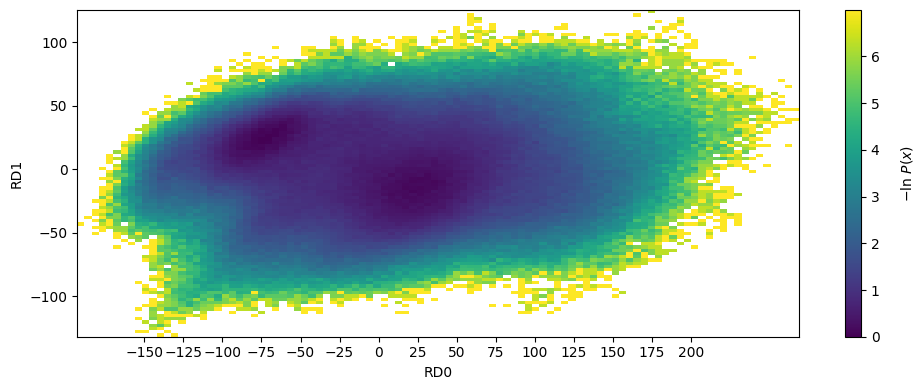

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xticks([i for i in range(-150, 225, 25)])
mdap.MD_Plot(Xname=reduced_data[:,0], xlabel="RD0", Xindex=0, 
             Yname=reduced_data[:,1], ylabel="RD1", Yindex=0, data_type="pdist", ax=ax).plot()
plt.show()

Step 5: Build an MSM from VAMP-reduced data

In [ ]:
# Discretize the reduced data using clustering
from sklearn.cluster import KMeans
n_clusters = 100  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
discrete_data = kmeans.fit_predict(reduced_data)

Cluster using stratified kmeans instead

In [16]:
from sklearn.cluster import KMeans
from mr_toolkit.clustering import StratifiedClusters

In [26]:
# clusters per strata
n_clusters = 100
# bins in vamp0 space
#bounds = [i for i in range(-125, 200, 25)]
bounds = [i for i in range(-150, 225, 25)]
len(bounds)

15

In [27]:
# clustering
clusterer = StratifiedClusters(n_clusters, bin_bounds=bounds)
clusterer.fit(reduced_data, coord_to_stratify=0)
discrete_data = clusterer.predict(reduced_data)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [28]:
discrete_data

array([721, 765, 629, ..., 656, 792, 792], shape=(1066178,))

In [29]:
clusterer.cluster_centers

array([[-160.01251149,  -17.38761857,   -6.67269513, ...,   -7.55537736,
           9.25199643,    1.76160458],
       [-159.17553297,  -14.43160442,   13.48969352, ...,    0.79225866,
           1.04303217,    3.68117692],
       [-157.84203   ,  -14.06887965,   11.84233428, ...,    1.65455203,
          -0.62538701,    3.11210836],
       ...,
       [ 211.31173979,   47.20076967,  -34.12671164, ...,    0.91263606,
          -4.70021902,   -5.86482365],
       [ 203.66451827,    5.50228674,   -2.92600257, ...,    9.95759568,
          -4.13226229,    1.91988849],
       [ 207.00613495,   51.96528937,  -13.65702795, ...,    1.16147782,
          -1.42507674,    1.25268525]], shape=(1600, 20))

Build MSM

In [30]:
# Construct the MSM, using 1 step/ 10ps lagtime
msm = deeptime.markov.msm.MaximumLikelihoodMSM(lagtime=1)
msm_model = msm.fit(discrete_data).fetch_model()

In [31]:
# Save the MSM for future analysis
with open("msm_model_full.pkl", "wb") as f:
    pickle.dump([discrete_data, clusterer.cluster_centers, msm_model], f)

### Build SynD model from MSM

In [2]:
from synd.models.discrete.markov import MarkovGenerator
from synd.core import load_model

In [3]:
from scipy import sparse
from scipy.cluster.vq import vq

In [4]:
# Read previous data
with open(f'msm_model_full.pkl','rb') as file:
    [final_cluster, cluster_centers, final_msm] = pickle.load(file)

Load VAMP data

In [5]:
features = np.load("pca_reduced_data_full.npy")

#### Define backmapping coordinates (xyz coords)

In [36]:
# first grab frame for each cluster center
frames, _ = vq(cluster_centers, features)
print(f"frame index per cluster:\n {frames}")

frame index per cluster:
 [111499 114574 124050 ... 764371 583056 562511]


I need to create a dict that maps each cluster to the coord space, e.g.
``` Python
{0: array([0.19300674, ...]),
 1: array([0.14842148, ...]),
 2: array([0.12663524, ...]),
 3: array([0.16085377, ...]),
 ...
 ```
Where the array = xyz coordinates of all T4L atoms

Load in the trajectory

In [37]:
u = mda.Universe("sim1_dry.pdb", "sim1-imaged.xtc", in_memory=True, in_memory_step=1)

In [38]:
u.trajectory.n_frames

1066178

In [39]:
from MDAnalysis.analysis import align

In [40]:
def extract_frame_coords(u, frame, reference="sim1_dry.pdb"):
    """
    Extracts the coordinates for a specific frame of a trajectory, aligned to a reference structure.

    Parameters
    ----------
    u : MDAnalysis.Universe
        Universe containing the trajectory.
    frame : int
        The index of the frame to extract.
    reference : str
        Path to the reference structure (e.g., a PDB file) to align to.

    Returns
    -------
    numpy.ndarray
        Aligned coordinates of the selected frame, shape (n_atoms, 3).
    """
    # Load the reference structure
    ref = mda.Universe(reference)
    
    # Select the specific frame
    u.trajectory[frame]
    
    # Select the desired atoms (e.g., all atoms, backbone, or custom selection)
    atom_group = u.select_atoms("all")
    ref_atoms = ref.select_atoms("all")  # Match selection with trajectory
    
    # Perform alignment of the current frame to the reference structure
    alignment = align.alignto(atom_group, ref_atoms, weights="mass")
    
    # Extract the aligned coordinates for the selected frame
    coordinates = atom_group.positions  # Numpy array of shape (n_atoms, 3)
    
    return coordinates


In [41]:
# The keys of the dict are just the cluster index
c_index = [i for i in range(frames.shape[0])]

In [43]:
# and then store the coordiantes as the backmapper
n_frames = len(frames) # n_clusters
n_atoms = u.atoms.n_atoms

# Pre-allocate the array for storing all coordinates
coordinates = np.zeros((n_frames, n_atoms, 3), dtype=np.float16)
for i, f in tqdm(enumerate(frames), total=n_frames):
    coordinates[i] = extract_frame_coords(u, f)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [44]:
coordinates[0]

array([[72.3 , 47.5 , 27.14],
       [73.25, 47.6 , 26.9 ],
       [72.25, 47.22, 28.12],
       ...,
       [77.06, 54.3 , 19.58],
       [78.1 , 53.75, 19.67],
       [77.  , 55.53, 19.38]], shape=(2612, 3), dtype=float16)

In [45]:
# okay, now make it into a dict
backmapper = dict(zip(c_index, coordinates))

In [46]:
backmapper

{0: array([[72.3 , 47.5 , 27.14],
        [73.25, 47.6 , 26.9 ],
        [72.25, 47.22, 28.12],
        ...,
        [77.06, 54.3 , 19.58],
        [78.1 , 53.75, 19.67],
        [77.  , 55.53, 19.38]], shape=(2612, 3), dtype=float16),
 1: array([[72.1 , 48.22, 25.38],
        [72.44, 47.6 , 26.08],
        [71.6 , 47.62, 24.72],
        ...,
        [76.4 , 55.3 , 18.78],
        [75.7 , 55.84, 17.86],
        [77.6 , 55.38, 18.75]], shape=(2612, 3), dtype=float16),
 2: array([[73.56, 48.94, 27.03],
        [73.6 , 48.03, 26.61],
        [74.4 , 49.5 , 26.67],
        ...,
        [76.8 , 55.47, 20.36],
        [77.94, 55.1 , 20.2 ],
        [76.56, 56.72, 20.48]], shape=(2612, 3), dtype=float16),
 3: array([[72.56, 48.7 , 26.11],
        [73.4 , 48.7 , 26.73],
        [72.1 , 47.8 , 26.23],
        ...,
        [77.25, 55.3 , 21.94],
        [76.94, 56.34, 22.56],
        [78.3 , 54.7 , 22.03]], shape=(2612, 3), dtype=float16),
 4: array([[73.  , 48.5 , 27.1 ],
        [72.7 , 48.2 ,

In [47]:
backmapper[0].shape

(2612, 3)

In [48]:
# save backmapper
with open("backmapper_full.pkl", "wb") as f:
    pickle.dump(backmapper, f)

In [6]:
# open backmapper
with open(f'backmapper_full.pkl','rb') as file:
    backmapper = pickle.load(file)

#### Now create and save SynD model

In [7]:
synd_model = MarkovGenerator(
    transition_matrix=final_msm.transition_matrix,
    backmapper=backmapper.get,
    seed=None,
)

In [8]:
synd_model.save('t4l.synd')

Run SynD from arbitrary initial state

In [9]:
%%time

# each step = 1ps
trajectory = synd_model.generate_trajectory(
    initial_states=np.array([0]),
    n_steps=200,
)
trajectory

CPU times: user 2.01 ms, sys: 0 ns, total: 2.01 ms
Wall time: 2.03 ms


array([[   0,    0,    0,  174,   22,  174,  174,  174,  174,  235,  235,
         235,  235,  235,  319,  311,  311,  412,  412,  412,  412,  570,
         570,  576,  576,  576,  576,  576,  576,  508,  508,  554,  554,
         554,  507,  507,  507,  507,  530,  699,  719,  719,  719,  719,
         684,  624,  624,  538,  477,  477,  477,  538,  538,  618,  618,
         639,  639,  639,  639,  657,  657,  671,  671,  731,  784,  881,
         814,  814,  718,  605,  605,  605,  696,  634,  651,  651,  605,
         507,  507,  598,  442,  507,  507,  507,  667,  667,  667,  667,
         502,  552,  676,  676,  783,  831,  976,  843,  973,  834,  834,
         889,  889,  889,  889,  719,  724,  724,  699,  528,  528,  591,
         471,  538,  538,  477,  477,  403,  536,  610,  671,  671,  796,
         796,  796,  796,  796,  796,  724,  724,  606,  671,  752,  752,
         735,  747,  731,  747,  747,  747,  715,  881,  881,  715,  715,
         715,  648,  686,  648,  648, 

In [10]:
trajectory.shape

(1, 200)

In [11]:
mapped_traj = synd_model.backmap(trajectory)

In [12]:
mapped_traj.shape

(1, 200, 2612, 3)

In [13]:
mapped_traj

array([[[[72.3 , 47.5 , 27.14],
         [73.25, 47.6 , 26.9 ],
         [72.25, 47.22, 28.12],
         ...,
         [77.06, 54.3 , 19.58],
         [78.1 , 53.75, 19.67],
         [77.  , 55.53, 19.38]],

        [[72.3 , 47.5 , 27.14],
         [73.25, 47.6 , 26.9 ],
         [72.25, 47.22, 28.12],
         ...,
         [77.06, 54.3 , 19.58],
         [78.1 , 53.75, 19.67],
         [77.  , 55.53, 19.38]],

        [[72.3 , 47.5 , 27.14],
         [73.25, 47.6 , 26.9 ],
         [72.25, 47.22, 28.12],
         ...,
         [77.06, 54.3 , 19.58],
         [78.1 , 53.75, 19.67],
         [77.  , 55.53, 19.38]],

        ...,

        [[72.1 , 47.5 , 27.  ],
         [71.75, 46.94, 26.23],
         [73.1 , 47.7 , 26.92],
         ...,
         [73.  , 59.25, 18.73],
         [72.7 , 60.47, 18.7 ],
         [73.4 , 58.66, 17.7 ]],

        [[72.1 , 47.5 , 27.  ],
         [71.75, 46.94, 26.23],
         [73.1 , 47.7 , 26.92],
         ...,
         [73.  , 59.25, 18.73],
         [72

#### Now convert back to MDAnalysis universe and do analysis

In [14]:
syn_u = mda.Universe("sim1_dry.pdb")

In [15]:
syn_u.load_new(mapped_traj[0], format="memory")

<Universe with 2612 atoms>

In [16]:
syn_u.trajectory

<MemoryReader with 200 frames of 2612 atoms>

Example RoG calc

In [17]:
# calculation of radius of gyration for the whole trajectory
rog = np.array([syn_u.atoms.radius_of_gyration() for ts in syn_u.trajectory])

In [18]:
rog.shape

(200,)

In [19]:
rog

array([16.28184996, 16.28184996, 16.28184996, 16.36831372, 16.39940279,
       16.36831372, 16.36831372, 16.36831372, 16.36831372, 16.4177039 ,
       16.4177039 , 16.4177039 , 16.4177039 , 16.4177039 , 16.56087084,
       16.55315128, 16.55315128, 16.63284957, 16.63284957, 16.63284957,
       16.63284957, 16.7055418 , 16.7055418 , 16.70322295, 16.70322295,
       16.70322295, 16.70322295, 16.70322295, 16.70322295, 16.80834634,
       16.80834634, 16.74508008, 16.74508008, 16.74508008, 16.65482969,
       16.65482969, 16.65482969, 16.65482969, 16.73247326, 16.83734302,
       16.95566821, 16.95566821, 16.95566821, 16.95566821, 16.84390332,
       16.91001511, 16.91001511, 16.85813782, 16.70146568, 16.70146568,
       16.70146568, 16.85813782, 16.85813782, 16.94172866, 16.94172866,
       16.83417728, 16.83417728, 16.83417728, 16.83417728, 16.85621142,
       16.85621142, 16.79584038, 16.79584038, 16.89758599, 16.97018105,
       16.99302041, 17.0217415 , 17.0217415 , 16.87250785, 16.79

In [20]:
plt.plot(rog)

#### Finally, save synthetic traj out to an xtc file:

In [25]:
from MDAnalysis.coordinates.XTC import XTCWriter

In [36]:
# Define the output file name
output_xtc = "synd_test.xtc"

# Create an XTCWriter object
with XTCWriter(output_xtc, n_atoms=syn_u.atoms.n_atoms) as writer:
    for ts in syn_u.trajectory:
        writer.write(syn_u.atoms) 

Test load back in:

In [37]:
u = mda.Universe("sim1_dry.pdb", output_xtc)

In [38]:
u.trajectory

<XTCReader synd_test.xtc with 200 frames of 2612 atoms>

In [39]:
rog = np.array([u.atoms.radius_of_gyration() for ts in u.trajectory])

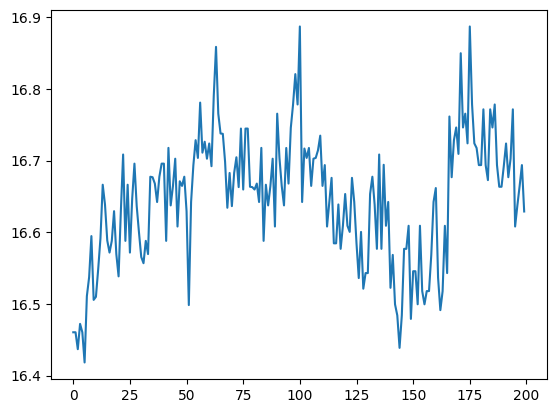

In [40]:
plt.plot(rog)

## The condensed pipeline:
---

In [51]:
%%time

# each step = 1ps
trajectory = synd_model.generate_trajectory(
    initial_states=np.array([0]),
    n_steps=1000000, # 1us
)
trajectory

CPU times: user 6.59 s, sys: 1.03 ms, total: 6.59 s
Wall time: 6.61 s


array([[   0,   19,   19, ..., 1144, 1144, 1144]], shape=(1, 1000000))

In [52]:
# optionally less frames (every 100ps)
trajectory[:,::100].shape

(1, 10000)

In [53]:
mapped_traj = synd_model.backmap(trajectory[:,::100])

In [54]:
syn_u = mda.Universe("sim1_dry.pdb")

In [55]:
syn_u.load_new(mapped_traj[0], format="memory")

<Universe with 2612 atoms>

In [56]:
syn_u.trajectory

<MemoryReader with 10000 frames of 2612 atoms>

Example RoG calc

In [57]:
# calculation of radius of gyration for the whole trajectory
rog = np.array([syn_u.atoms.radius_of_gyration() for ts in syn_u.trajectory])

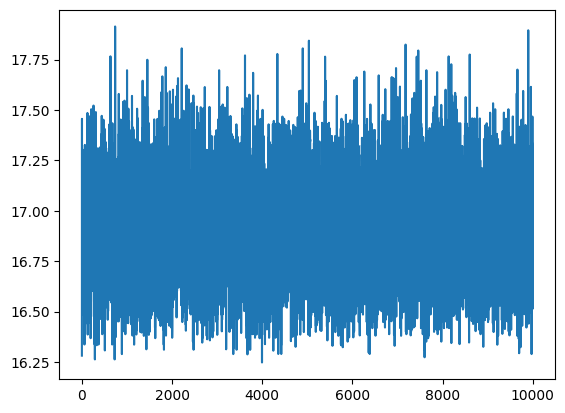

In [61]:
plt.plot(rog)
plt.show()

In [64]:
# Define the output file name
output_xtc = "synd_1us.xtc"

# Create an XTCWriter object
with mda.coordinates.XTC.XTCWriter(output_xtc, n_atoms=syn_u.atoms.n_atoms) as writer:
    for ts in syn_u.trajectory:
        writer.write(syn_u.atoms) 

---
### Create a separate heavy-atom RMSD mapper
---

In [11]:
import MDAnalysis.analysis.rms

In [6]:
 def calc_heavy_atom_rmsd(u, reference_pdb, selection="protein and not name H*"):
    """
    Calculate the RMSD of heavy atoms (or a custom selection) for a trajectory compared to a reference structure.

    Parameters
    ----------
    u : MDAnalysis.Universe
        Universe object for the trajectory.
    reference_pdb : str
        Path to the reference PDB file.
    selection : str
        Atom selection string for selecting heavy atoms. Default is "protein and not name H*".

    Returns
    -------
    numpy.ndarray
        RMSD values for each frame, shape (n_frames,).
    """
    # Load the universe for the trajectory and reference
    #u = mda.Universe(reference_pdb, traj)
    ref = mda.Universe(reference_pdb)

    # Select heavy atoms in both reference and trajectory
    ref_atoms = ref.select_atoms(selection)
    traj_atoms = u.select_atoms(selection)

    # Check that both selections have the same number of atoms
    assert ref_atoms.n_atoms == traj_atoms.n_atoms, \
        f"Atom selection mismatch: reference has {ref_atoms.n_atoms}, trajectory has {traj_atoms.n_atoms}"

    # Perform the RMSD calculation
    rmsd_analysis = MDAnalysis.analysis.rms.RMSD(traj_atoms, ref_atoms)
    rmsd_analysis.run()

    # Extract RMSD values (in Ångstroms) for all frames
    # Column 2 contains RMSD values: frame | time | RMSD
    rmsd_values = rmsd_analysis.results.rmsd[:, 2]

    return rmsd_values

In [7]:
# load full traj
tpr = "sim1_dry.pdb"
xtc = "sim1-imaged.xtc"
u = mda.Universe(tpr, xtc, in_memory=True, in_memory_step=1)

In [12]:
# calc RMSD values
rmsd = calc_heavy_atom_rmsd(u, tpr)

In [13]:
rmsd.shape

(1066178,)

#### Make an rmsd backmapping dict

In [14]:
from scipy import sparse
from scipy.cluster.vq import vq

In [15]:
# Read previous data
with open(f'msm_model_full.pkl','rb') as file:
    [final_cluster, cluster_centers, final_msm] = pickle.load(file)

In [5]:
features = np.load("pca_reduced_data_full.npy")

In [17]:
features.shape

(1066178, 20)

In [19]:
cluster_centers.shape

(1600, 20)

In [20]:
# first grab frame for each cluster center
frames, _ = vq(cluster_centers, features)
print(f"frame index per cluster:\n {frames}")

frame index per cluster:
 [111499 114574 124050 ... 764371 583056 562511]


Now I need to create a list of RMSD values at each frame index:

Pretty straitforward.

In [23]:
rmsd[frames].shape

(1600,)

In [24]:
# The keys of the dict are just the cluster index
c_index = [i for i in range(frames.shape[0])]

In [25]:
# okay, now make it into a dict
backmapper = dict(zip(c_index, rmsd[frames]))

In [26]:
backmapper

{0: 2.6842216249906037,
 1: 2.3467959652075776,
 2: 2.2799469434665425,
 3: 2.340690124660804,
 4: 2.6388085849736482,
 5: 2.472706231583088,
 6: 2.3255723448831818,
 7: 2.5539616323959975,
 8: 2.3211387582073986,
 9: 2.441760456741066,
 10: 2.820689999724022,
 11: 2.334454756118783,
 12: 2.5459917858877072,
 13: 2.368292382626603,
 14: 2.491887169310345,
 15: 2.3739986618869655,
 16: 2.4126212169055776,
 17: 2.517472918157018,
 18: 2.4378623996204767,
 19: 2.8528506985972135,
 20: 2.302505849832652,
 21: 2.534088378015501,
 22: 2.755730936699371,
 23: 2.3055145565858135,
 24: 2.345045890991913,
 25: 2.429467696572109,
 26: 2.8045423179551587,
 27: 2.372434909402623,
 28: 2.3313152369854717,
 29: 2.2768770471337367,
 30: 2.445914926381079,
 31: 2.406911200662351,
 32: 2.4265907280309253,
 33: 2.4134403721186297,
 34: 2.38749447170915,
 35: 2.436134201518766,
 36: 2.257803174371575,
 37: 2.5366615430522956,
 38: 2.7166556983542702,
 39: 2.1236387498254006,
 40: 2.764864835037769,
 41: 2

In [29]:
# save backmapper
with open("backmapper_rmsd.pkl", "wb") as f:
    pickle.dump(backmapper, f)